In [1]:
import os
from importlib.resources import files
import time

import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
# Enable LaTeX rendering and set Times as the font family
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry
from learn_embedding.utils import *
from learn_embedding.loss import *

In [2]:
# problem dimension
dim = 2
# Total number of trajectories
num_traj = 7
# Number of trajectories used for training
num_train = 4
# sampling frequency
dt = 0.001
# Desired number of samples per trajectory
num_samples = 1000
# dynamics order
second_order = True
# number of repetitions
reps = 5
# number of neurons per layer
num_neurons = [32, 64] # [8, 16, 32, 64, 128, 256]
# number of layers
num_layers = [1, 2, 3] # [1, 2, 3, 4, 5, 6]
# maximum number of iterations
max_iter = 5e5
# loss tolerance
loss_tol = 1e-10
# cuda
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
delta_t = []
sampled_x, sampled_y = [], []
for i in range(num_traj):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/synthetic/trajectory_" + str(i+1) + ".csv")
    t = np.arange(0, data.shape[0]*dt, dt)
    # remove last point
    data = data[:-1,:]
    t = t[:-1]
    # subsample
    if num_samples is not None:
        idx = DataProcess.subsample(data[:,:2], num_samples)
        data = data[idx]
        t = t[idx]
    # center
    data[:,:2] -= data[-1,:2]
    # zero velocity last sample
    data[-1,2:4] = np.zeros(2)
    # zero acceleration last sample
    data[-1,-2:] = np.zeros(2)
    # add delta time
    delta_t.append(np.append(t[1:]-t[:-1],0))
    # add trajectory
    sampled_x.append(data[:,:2*dim] if second_order else data[:,:dim])
    sampled_y.append(data[:,-2:] if second_order else data[:,dim:2*dim])

In [4]:
def train_model(model, train_x, train_y):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200, 
                                                           threshold=1e-3, threshold_mode='rel', cooldown=0, 
                                                           min_lr=0, eps=1e-8, verbose=False)
    loss_fun = torch.nn.MSELoss()
    epochs = 0
    prev_loss = 1e6
    
    t0 = time.time()
    while epochs <= max_iter:
        optimizer.zero_grad()
        pred = model(train_x)
        loss = loss_fun(pred,train_y)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        if np.abs(loss.item() - prev_loss) <= loss_tol:
            break
        prev_loss = loss.item()
        epochs += 1
    return loss.item(), epochs, time.time()-t0

In [5]:
# cosine similarity kernel
cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

# loss, epochs, time, rmse, cos
results_log = np.zeros((5, len(num_layers), len(num_neurons), reps))

for i, l in enumerate(num_layers):
    for j, n in enumerate(num_neurons):
        for k in range(reps):
            if second_order:
                model = SecondGeometry(Embedding(FeedForward(dim, [n]*l, 1)), torch.tensor([0,0]).to(device), SPD(dim), SPD(dim)).to(device)
            else:
                model = FirstGeometry(Embedding(FeedForward(dim, [n]*l, 1)), torch.tensor([0,0]).to(device), SPD(dim)).to(device)
                
            rand_idx = list(np.random.permutation(num_traj))
            train_x = torch.from_numpy(np.concatenate(list(sampled_x[q] for q in rand_idx[:num_train]), axis=0)).float().to(device).requires_grad_(True)
            train_y = torch.from_numpy(np.concatenate(list(sampled_y[q] for q in rand_idx[:num_train]), axis=0)).float().to(device)
            loss, epochs, train_time = train_model(model, train_x, train_y)

            rmse, cos = 0.0, 0.0
            for z in rand_idx[num_train:]:
                test_x = torch.from_numpy(sampled_x[z]).float().to(device).requires_grad_(True)
                test_y = torch.from_numpy(sampled_y[z]).float().to(device)
                test_dt = torch.from_numpy(delta_t[z]).float().unsqueeze(-1).to(device)
                if second_order:
                    output = (test_x[:-1, 2:] + test_dt[:-1]*model(test_x[:-1])).detach()
                    rmse += (output-test_x[1:, 2:].detach()).square().sum().mean().sqrt()/(num_traj-num_train)
                    cos += (1 - cosine_similarity(output, test_x[1:, 2:].detach())).mean()/(num_traj-num_train)
                else:
                    output = model(test_x).detach()
                    rmse += (output-test_y).square().sum().mean().sqrt()/(num_traj-num_train)
                    cos += (1 - cosine_similarity(output, test_y)).mean()/(num_traj-num_train)
            
            results_log[0,i,j,k] = np.round(loss, 5)
            results_log[1,i,j,k] = np.round(epochs, 5)
            results_log[2,i,j,k] = np.round(train_time, 5)
            results_log[3,i,j,k] = np.round(rmse.item(), 5)
            results_log[4,i,j,k] = np.round(cos.item(), 5)
            print("L: ", l, "N: ", n, "R: ", k, 
                  "Loss: ", results_log[0,i,j,k], "Epochs: ", results_log[1,i,j,k], "Time: ", results_log[2,i,j,k], 
                  "RMSE: ", results_log[3,i,j,k], "COS: ", results_log[4,i,j,k])

L:  1 N:  32 R:  0 Loss:  0.00055 Epochs:  12059.0 Time:  68.1145 RMSE:  0.03153 COS:  0.00107
L:  1 N:  32 R:  1 Loss:  0.00103 Epochs:  26168.0 Time:  147.6241 RMSE:  0.02266 COS:  0.00106
L:  1 N:  32 R:  2 Loss:  0.00116 Epochs:  19582.0 Time:  110.91988 RMSE:  0.02536 COS:  0.00122
L:  1 N:  32 R:  3 Loss:  0.0015 Epochs:  7757.0 Time:  43.93452 RMSE:  0.02266 COS:  0.0011
L:  1 N:  32 R:  4 Loss:  0.00052 Epochs:  17709.0 Time:  98.8097 RMSE:  0.02555 COS:  0.00106
L:  1 N:  64 R:  0 Loss:  0.00078 Epochs:  16560.0 Time:  93.70556 RMSE:  0.05774 COS:  0.00183
L:  1 N:  64 R:  1 Loss:  0.00095 Epochs:  16455.0 Time:  93.72219 RMSE:  0.06031 COS:  0.00188
L:  1 N:  64 R:  2 Loss:  0.00105 Epochs:  22406.0 Time:  125.06324 RMSE:  0.02759 COS:  0.00111
L:  1 N:  64 R:  3 Loss:  0.00064 Epochs:  24332.0 Time:  142.79587 RMSE:  0.05722 COS:  0.00178
L:  1 N:  64 R:  4 Loss:  0.00089 Epochs:  7665.0 Time:  43.51349 RMSE:  0.04869 COS:  0.00153
L:  2 N:  32 R:  0 Loss:  0.00083 Epochs:  

In [6]:
results_mean = results_log.mean(axis=3)
results_std = results_log.std(axis=3)
# boxplot_data = [results_log[3,0,0,:], results_log[3,0,1,:], results_log[3,0,2,:]]

In [7]:
results_mean[3]

array([[0.025552, 0.05031 ],
       [0.035696, 0.038176],
       [0.058856, 0.139594]])

In [8]:
results_mean[4]

array([[0.001102, 0.001626],
       [0.001082, 0.001176],
       [0.001104, 0.001242]])

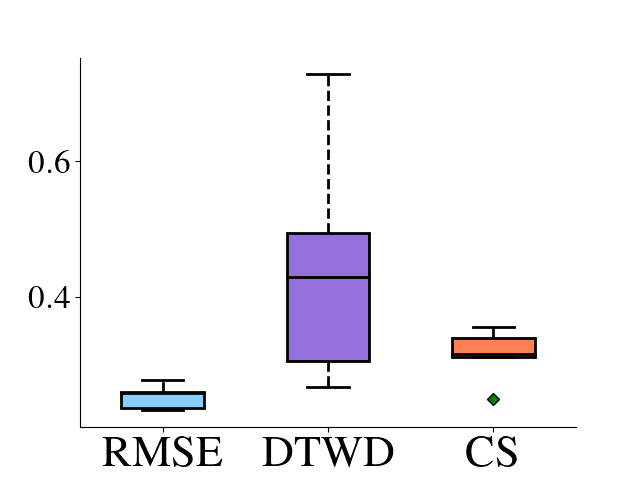

In [36]:
fig, ax = plt.subplots()
boxprops = dict(linewidth=2, facecolor='lightgray')  # No edge for the boxes
medianprops = dict(linewidth=2, color='black', linestyle='-')
whiskerprops = dict(linewidth=2, color='black', linestyle='--')  # Dashed whiskers
capprops = dict(linewidth=2, color='black')
flierprops = dict(markerfacecolor='g', marker='D')  # Green diamonds for outliers
boxplot = ax.boxplot(boxplot_data, boxprops=boxprops, medianprops=medianprops,
                     whiskerprops=whiskerprops, capprops=capprops, 
                     flierprops=flierprops, patch_artist=True, widths=0.5)
colors = ['lightskyblue', 'mediumpurple', 'coral']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticks([1, 2, 3], ['RMSE', 'DTWD', 'CS'], fontsize=32)
# ax.set_yticks([],fontsize=12)
ax.tick_params(axis='y', labelsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)